## Data Preprocessing

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [36]:
# import dataframes
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [37]:
# investigate dataframes
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
df_test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


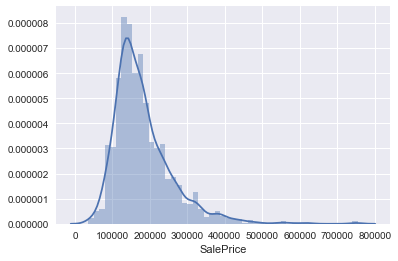

In [39]:
# investigate target label
print(df_train['SalePrice'].describe())
sns.distplot(df_train['SalePrice'])
plt.show()

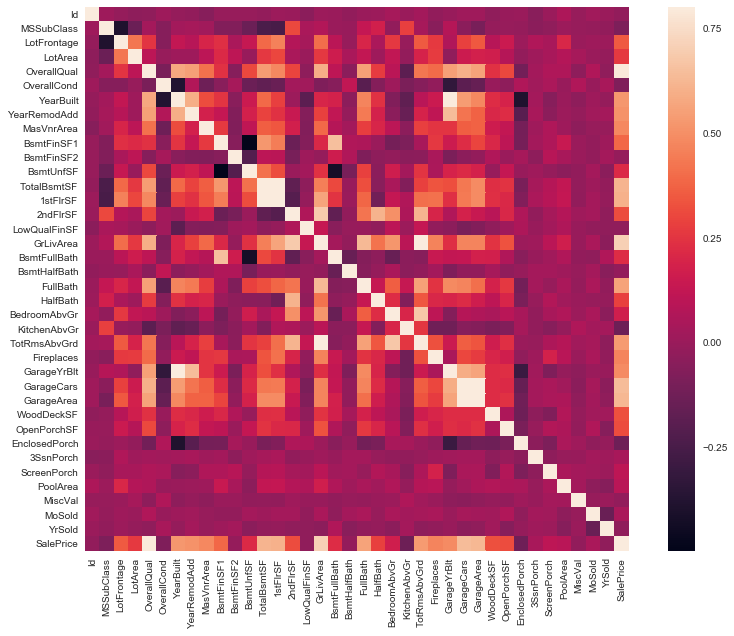

In [40]:
# correlation matrix
correlation_matrix = df_train.corr()
plt.figure(figsize=(14,10))
sns.heatmap(correlation_matrix, vmax=0.8, square=True)
plt.show()

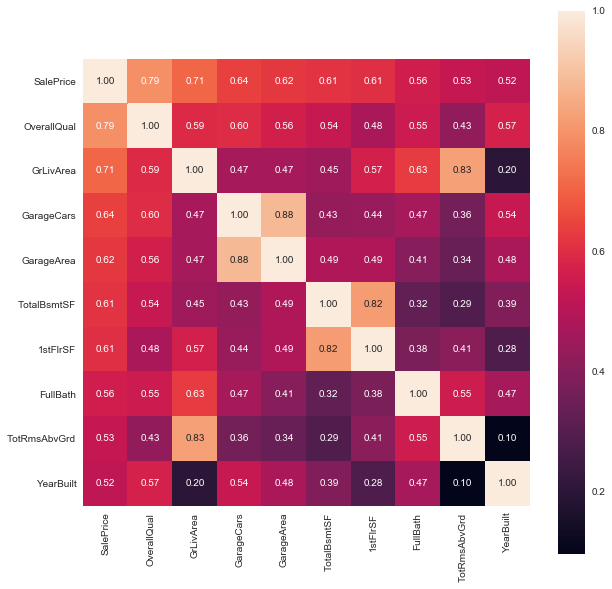

In [41]:
# correlation matrix with focus on SalePrice
k = 10
cols = correlation_matrix.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
plt.figure(figsize=(10,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='0.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

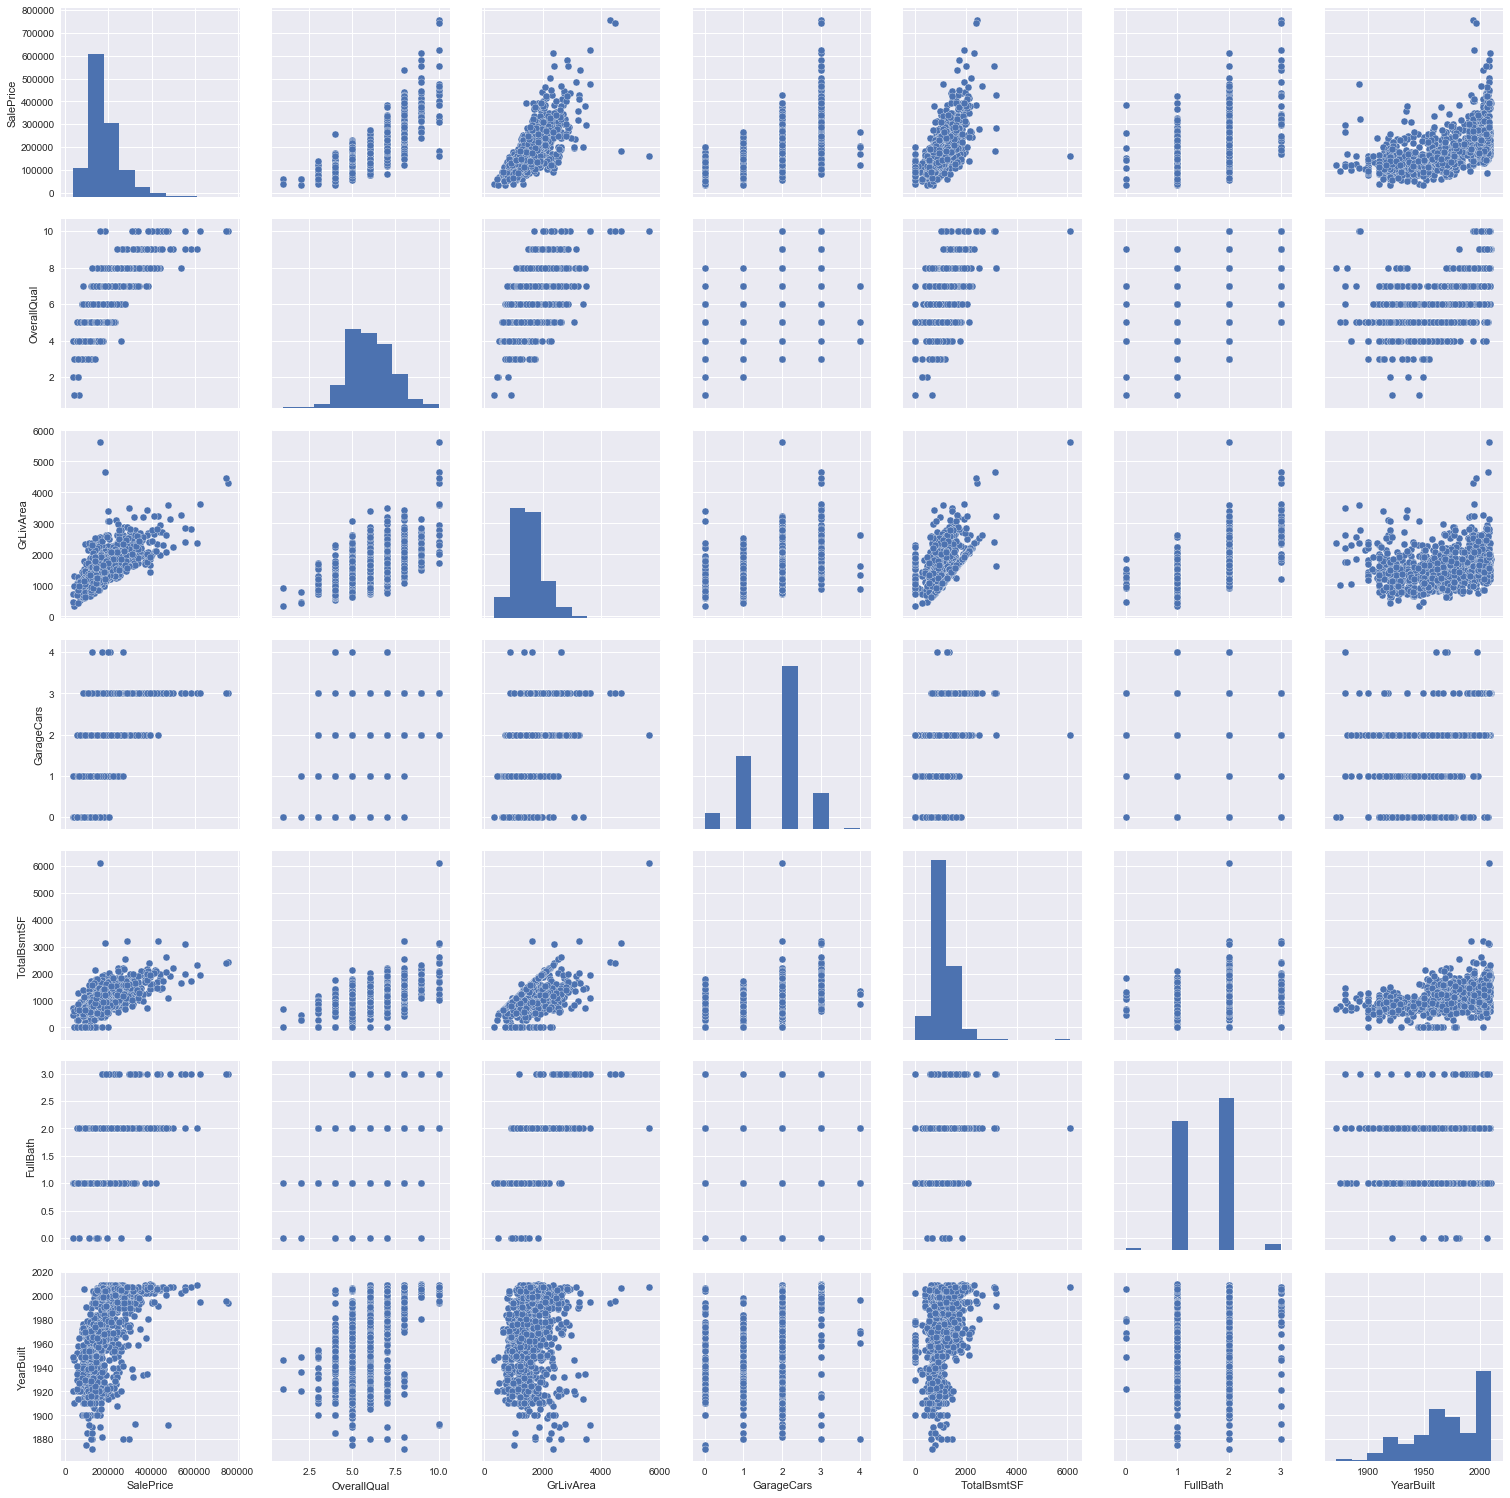

In [42]:
# scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size=3)
plt.show()

In [43]:
# delete outliers
df_train.sort_values(by = 'GrLivArea', ascending=False)[:2]
df_train = df_train.drop(df_train[df_train['Id']==1299].index)
df_train = df_train.drop(df_train[df_train['Id']==524].index)

In [44]:
# feature engineering
# concatenate train and test date in one dataframe
len_train = df_train.shape[0]
len_test = df_test.shape[0]
y_train = df_train.SalePrice.values
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)
df_all.drop(['SalePrice'], axis=1, inplace=True)
df_all.drop(['Id'], axis=1, inplace=True)
print(len_train)
print(len_test)
print(df_all.shape)

1458
1459
(2917, 79)


In [45]:
# missing data
total = df_all.isnull().sum().sort_values(ascending=False)
percent = (df_all.isnull().sum()/df_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageCond,159,0.054508


In [46]:
# handeling missing data
df_all['PoolQC'] = df_all['PoolQC'].fillna('None')
df_all['MiscFeature'] = df_all['MiscFeature'].fillna('None')
df_all['Alley'] = df_all['Alley'].fillna('None')
df_all['Fence'] = df_all['Fence'].fillna('None')
df_all['FireplaceQu'] = df_all['FireplaceQu'].fillna('None')

df_all['LotFrontage'] = df_all.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_all[col] = df_all[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_all[col] = df_all[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_all[col] = df_all[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_all[col] = df_all[col].fillna('None')
    
df_all["MasVnrType"] = df_all["MasVnrType"].fillna("None")
df_all["MasVnrArea"] = df_all["MasVnrArea"].fillna(0)

df_all['MSZoning'] = df_all['MSZoning'].fillna(df_all['MSZoning'].mode()[0])

df_all = df_all.drop(['Utilities'], axis=1)

df_all["Functional"] = df_all["Functional"].fillna("Typ")

df_all['Electrical'] = df_all['Electrical'].fillna(df_all['Electrical'].mode()[0])

df_all['KitchenQual'] = df_all['KitchenQual'].fillna(df_all['KitchenQual'].mode()[0])

df_all['Exterior1st'] = df_all['Exterior1st'].fillna(df_all['Exterior1st'].mode()[0])
df_all['Exterior2nd'] = df_all['Exterior2nd'].fillna(df_all['Exterior2nd'].mode()[0])

df_all['SaleType'] = df_all['SaleType'].fillna(df_all['SaleType'].mode()[0])

df_all['MSSubClass'] = df_all['MSSubClass'].fillna("None")

In [47]:
# check for missing data
total = df_all.isnull().sum().sort_values(ascending=False)
missing_values = pd.DataFrame(data=total)
missing_values.head(5)

,0
YrSold,0
Foundation,0
ExterCond,0
ExterQual,0
Exterior1st,0


In [48]:
# transforming specific numerical to categorical data
df_all['MSSubClass'] = df_all['MSSubClass'].apply(str)
df_all['OverallCond'] = df_all['OverallCond'].astype(str)
df_all['YrSold'] = df_all['YrSold'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

In [49]:
# encode categorical features
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    le = LabelEncoder()
    le.fit(list(df_all[c].values))
    df_all[c] = le.transform(list(df_all[c].values))

print(df_all.shape)

(2917, 78)


In [50]:
# add total sqfoot feature
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']
print(df_all.shape)

(2917, 79)


In [51]:
# sort numeric features by skewness
numeric_features = df_all.dtypes[df_all.dtypes != 'object'].index
skewed_features = df_all[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_df = pd.DataFrame({'Skewness': skewed_features})

In [52]:
skewness_df.head(5)

,Skewness
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080


In [53]:
# handle skewness
skewness_df = skewness_df[abs(skewness_df) > 0.75]
skewed_feat = skewness_df.index
lam = 0.15
for feat in skewed_feat:
    df_all[feat] = boxcox1p(df_all[feat], lam)

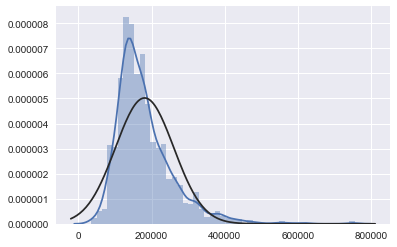

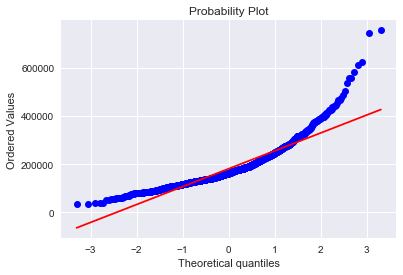

In [54]:
# skewness of target labels
sns.distplot(y_train, fit=norm)
plt.figure()
res = stats.probplot(y_train, plot=plt)



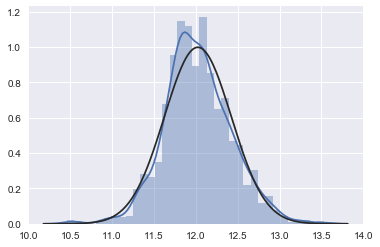

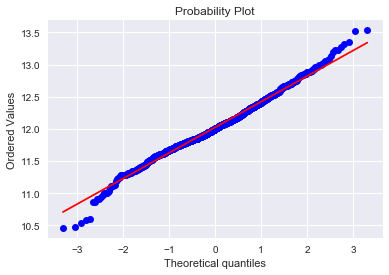

In [55]:
y_train = np.log(y_train)
sns.distplot(y_train, fit=norm)
plt.figure()
res=stats.probplot(y_train, plot=plt)


In [56]:
# get dummy variables
df_all = pd.get_dummies(df_all)
print(df_all.shape)

(2917, 220)


In [57]:
x_train = df_all[:len_train]
x_test = df_all[len_train:]
print(x_train.shape)
print(x_test.shape)

(1458, 220)
(1459, 220)


## Prediction Model (Stacked Regression)

In [58]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [59]:
# validation fuction
folds = 5

def rmsle_cv(model):
    kf = KFold(folds, shuffle=True, random_state=2).get_n_splits(x_train.values)
    rmse = np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
    return(rmse)

In [60]:
# base models
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=2))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


In [65]:
# base model scores

score_lasso = rmsle_cv(lasso)
print('Lasso:')
print('Mean: ', score_lasso.mean())
print('Std: ', score_lasso.std())


score_enet = rmsle_cv(ENet)
print('\nElasticNet:')
print('Mean: ', score_enet.mean())
print('Std: ', score_enet.std())

score_krr = rmsle_cv(KRR)
print('\nKernelRidge:')
print('Mean: ', score_enet.mean())
print('Std: ', score_enet.std())

Lasso:
Mean:  0.11154487064794952
Std:  0.007358151362436942

ElasticNet:
Mean:  0.11156302434196605
Std:  0.007403533421083917

KernelRidge:
Mean:  0.11156302434196605
Std:  0.007403533421083917


In [66]:
# stacking models class

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [67]:
# averaging models and score
averaged_models = AveragingModels(models = (ENet, lasso, KRR))
score = rmsle_cv(averaged_models)

print('Mean:', score.mean())
print('Std:', score.std())

Mean: 0.11086728797031868
Std: 0.0075481066641256075


In [69]:
# final training and prediction
averaged_models.fit(x_train.values, y_train)
prediction = np.expm1(averaged_models.predict(x_test.values))

In [70]:
# save submission
id_column = np.arange(1461,2920)
submission = pd.DataFrame()
submission['ID'] = id_column
submission['SalePrice'] = prediction
submission.to_csv('submission.csv', index=False)

In [71]:
# result:
# 0.11844 @ Kaggle
# helped sources:
# https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard